# BS Score over time

The primary goal of this notebook is to visualize the BS score over time under various groupings and conditions

Additionally, some of the processed datasets will be saved to disk for later use.

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
basmi_df = pd.read_excel('data/clean_basmi.xls', index_col=(0,1))

# Turn the Drug column into binary
basmi_df['Drug_Indicator'] = basmi_df['Drug'].notnull().map({False: 0, True: 1})
basmi_df.drop('Drug',axis=1, inplace=True)

patients = basmi_df.index.get_level_values('patient_id').unique()

print('Number of patients in basmi dataset:', len(patients))
print('Dimension of BS dataset:', basmi_df.shape)

print(basmi_df.head())

# Import demographics data
demo_df = pd.read_excel('./data/demographics and Biologics data.xlsx')
print('Dimension of demographics dataset:', demo_df.shape)

Number of patients in basmi dataset: 910
Dimension of BS dataset: (16210, 7)
                       CRS  TWS  LSFS  LFS  IMS   BS  Drug_Indicator
patient_id Date                                                     
40         1995-05-09    3    1     6    5    3  3.6               0
           1995-06-01    3    1     8    5    3  4.0               0
           1995-06-12    2    1     5    3    2  2.6               0
           1995-11-02    1    1     3    4    2  2.2               0
           1996-05-02    2    1     4    3    2  2.4               0
Dimension of demographics dataset: (721, 10)


## 1.  Normalize the patient timeline

Normalize each patient's timeline to be 0 at the time they joined the study. 

In [4]:
def get_norm_years(df):
    dates = df.index.get_level_values('Date')
    start_date = min(dates)
    norm_years = [int(pd.Timedelta(date - start_date).days / 365) for date in dates]
    return norm_years

basmi_df['norm_years'] = basmi_df.groupby(level=0)['BS'].transform(get_norm_years)
basmi_df.head(20)

CRS  TWS  LSFS  LFS  IMS   BS  Drug_Indicator  \
patient_id Date                                                        
40         1995-05-09    3    1     6    5    3  3.6               0   
           1995-06-01    3    1     8    5    3  4.0               0   
           1995-06-12    2    1     5    3    2  2.6               0   
           1995-11-02    1    1     3    4    2  2.2               0   
           1996-05-02    2    1     4    3    2  2.4               0   
           1997-02-06    3    1     5    4    2  3.0               0   
           1997-08-07    3    1     5    4    2  3.0               0   
           1998-05-06    3    1     7    4    2  3.4               0   
           1999-03-18    2    1     6    5    2  3.2               0   
           1999-03-31    2    1     6    5    1  3.0               0   
           1999-09-10    3    1     6    5    2  3.4               0   
           1999-09-16    3    1     6    5    3  3.6               0   
           2000-03-16    3    1     7    3    2  3.2               0   
           2000-09-08    4    1     5    4    2  3.2               0   
           2001-04-19    2    1     7    3    2  3.0               0   
           2002-03-14    3    1     7    5    2  3.6               0   
           2002-09-19    5    1     7    4    2  3.8               0   
           2002-11-18    4    2     8    5    4  4.6               0   
           2002-11-29    3    1     5    4    2  3.0               0   
           2003-03-20    2    1     4    4    2  2.6               0   

                       norm_years  
patient_id Date                    
40         1995-05-09         0.0  
           1995-06-01         0.0  
           1995-06-12         0.0  
           1995-11-02         0.0  
           1996-05-02         0.0  
           1997-02-06         1.0  
           1997-08-07         2.0  
           1998-05-06         2.0  
           1999-03-18         3.0  
           1999-03-31         3.0  
           1999-09-10         4.0  
           1999-09-16         4.0  
           2000-03-16         4.0  
           2000-09-08         5.0  
           2001-04-19         5.0  
           2002-03-14         6.0  
           2002-09-19         7.0  
           2002-11-18         7.0  
           2002-11-29         7.0  
           2003-03-20         7.0

## 2. Bin data per year for each patient
If patient has multiple measurements within a year, take the mean of those measurements.

Now each patient should have one score per year in study.

In [5]:
# BS data aggregated by patient for each year in study
agg_bs_df = basmi_df.groupby(['patient_id','norm_years']).agg({'BS': 'mean'}).reset_index(level=1)
agg_bs_df = agg_bs_df.round(2)
agg_bs_df

,norm_years,BS
patient_id,,
40,0.0,2.96
40,1.0,3.00
40,2.0,3.20
40,3.0,3.10
40,4.0,3.40
40,5.0,3.10
40,6.0,3.60
40,7.0,3.50
40,8.0,3.00


#### 3. Impute the missing values
If a patient missed a year, impute the missing value by assuming a linear progression

To get the progression rate, use the difference between BS scores before and after missing values and divide by the time difference.


In [10]:
fixed_dfs = []
for id, df in agg_bs_df.groupby('patient_id'):
    
    years = df['norm_years']

    bs_scores = df['BS'] 

    rate_of_change = (bs_scores.shift(-1) - bs_scores) / (years.shift(-1) - years)
    
    if df.shape[0] <= 1:
        fixed_df = pd.DataFrame({'BS': bs_scores, 'norm_years': years, 'patient_id': id})
    else:
        bs_scores.index = years
        rate_of_change.index = years

        # Full range of years - the actual years that patient was in the study
        years_range = pd.RangeIndex(0, stop=max(years))

        fixed_data = []
        last_bs_obs = None
        for year in years_range:
            # If we had data for this year, add set the last observation
            # and add this entry to fixed data
            if year in years.values:
                last_obs = (bs_scores.loc[year], rate_of_change.loc[year])
                fixed_data.append(last_obs[0])

            # Else, make a new observation by adding the rate of change to the last BS score we had
            # and updating the last observation to this new observation keeping the rate of change the same
            else:
                new_obs = last_obs[0] + last_obs[1]
                fixed_data.append(new_obs)
                last_obs = (new_obs, last_obs[1])

        fixed_df = pd.DataFrame({'BS': fixed_data, 'norm_years': years_range})
        fixed_df['patient_id'] = id
    
    fixed_dfs.append(fixed_df)
    
fixed_bs_df = pd.concat(fixed_dfs)

fixed_bs_df = fixed_bs_df.set_index('patient_id')
fixed_bs_df.to_excel('data/bs_normed.xls', index=False)

fixed_bs_df.head()

,BS,norm_years
patient_id,,
40,2.96,0.0
40,3.00,1.0
40,3.20,2.0
40,3.10,3.0
40,3.40,4.0


## Plotting the BS score and number of patients over time

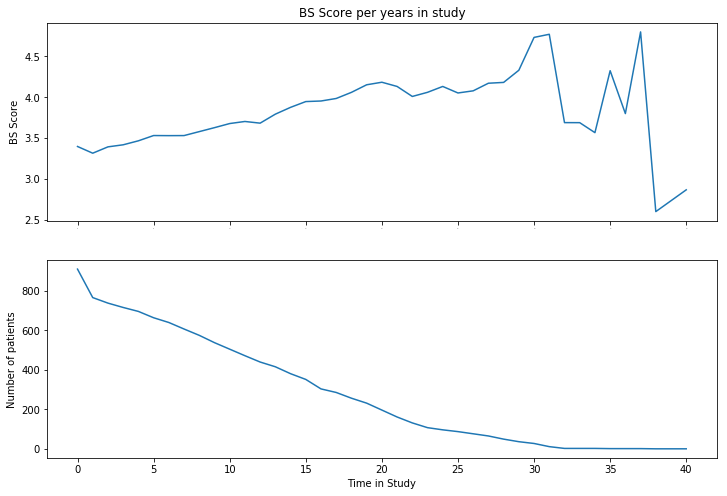

In [7]:
avg_by_norm_year = (fixed_bs_df.groupby('norm_years')
                    .agg({'BS': 'mean', 'norm_years': len})
                    .rename(columns={'norm_years': 'count'}))


fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot(211)
plt.plot(avg_by_norm_year['BS'])
plt.setp(ax1.get_xticklabels(), fontsize=0)
plt.title('BS Score per years in study')
ax1.set_ylabel('BS Score')

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(avg_by_norm_year['count'])
ax2.set_xlabel('Time in Study')
ax2.set_ylabel('Number of patients')

plt.show()

## Repeat the above analysis for both males and females

The first step is to identify which patients are male and female.

In [19]:
# Get patient ids of males and females
genders = demo_df['patient_gender_id'].values

# Get male and female index
male_ids = demo_df[genders == 'Male']['patient_id']
female_ids = demo_df[genders == 'Female']['patient_id']

# Get BS dataset of males and females
male_bs_df = fixed_bs_df[fixed_bs_df.reset_index()['patient_id'].isin(male_ids)]
female_bs_df = fixed_bs_df[fixed_bs_df.reset_index()['patient_id'].isin(female_ids)]

/home/lucasteyn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/home/lucasteyn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


## Plot BS score over time for males

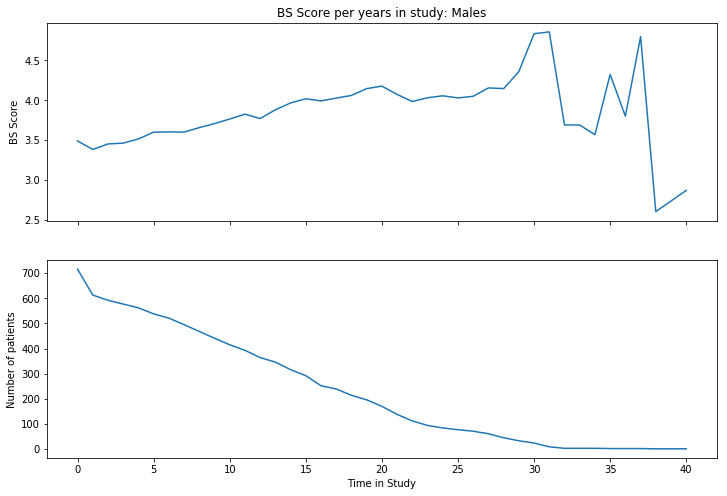

In [20]:
avg_by_norm_year = (male_bs_df.groupby('norm_years')
                    .agg({'BS': 'mean', 'norm_years': len})
                    .rename(columns={'norm_years': 'count'}))


fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot(211)
plt.plot(avg_by_norm_year['BS'])
plt.setp(ax1.get_xticklabels(), fontsize=0)
plt.title('BS Score per years in study: Males')
ax1.set_ylabel('BS Score')

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(avg_by_norm_year['count'])
ax2.set_xlabel('Time in Study')
ax2.set_ylabel('Number of patients')

plt.show()

## Plot BS over time for females

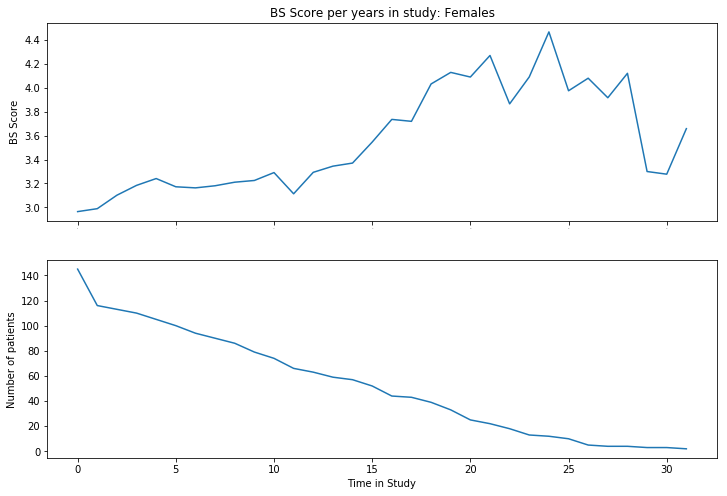

In [21]:
avg_by_norm_year = (female_bs_df.groupby('norm_years')
                    .agg({'BS': 'mean', 'norm_years': len})
                    .rename(columns={'norm_years': 'count'}))


fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot(211)
plt.plot(avg_by_norm_year['BS'])
plt.setp(ax1.get_xticklabels(), fontsize=0)
plt.title('BS Score per years in study: Females')
ax1.set_ylabel('BS Score')

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(avg_by_norm_year['count'])
ax2.set_xlabel('Time in Study')
ax2.set_ylabel('Number of patients')

plt.show()